# 5 决策树

决策树 (decision tree) 是形如 if-else 的分类方法. 决策树分类的好坏主要取决于各个条件的设计. 根据已有的训练数据, 决策树的重点是提取合适的特征条件.

为了选取"最有区分度"的特征, 可以利用信息熵的知识.

## 信息熵 

信息熵 (information entropy) 衡量信息量的多少. 对于一个离散概率分布
$$\mathbb P(X=X_i) = p_i \quad(i=1,2,\dotsc,n)$$
其熵定义为
$$H(\mathbb P) = -\sum_{i=1}^n p_i\log p_i$$

信息越混乱 (越不确定), 熵越大.

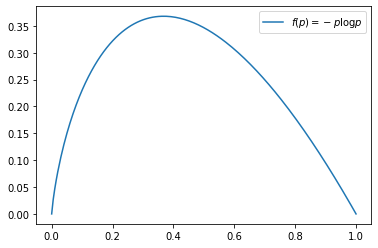

In [11]:
from matplotlib import pyplot as plt
import numpy as np
p = np.linspace(0, 1, 200)
h = -p * np.log(p + 1e-16) # + 1e-16 to prevent NaN
plt.plot(p, h)
plt.legend(['$f(p)=-p\log p$'])
plt.show()

### 条件熵

若离散分布 $Y$ 受到参数 $x$ 的影响, 当已先验地知道 $x$ 的分布 $X$ 时  (其中 $X$ 是离散分布), 可以定义条件熵 (conditional entropy) 
$$H(Y|X) = \mathbb E(H(Y)|X)= \sum_{i=1}^m p_iH(Y|X=x_i)$$

若离散分布 $Y$ 在未知与已知 $x\sim X$ 时的熵的变化称为信息增益 (information gain)
$$g(Y,X) = H(Y) - H(Y|X).$$

由于知道得多了, 信息更确定了, 信息熵一定减小, 即 $g\geqslant 0$.

证: 设离散分布 $Y$ 有 $n$ 类: $y_1,\dotsc,y_n$, 则
$$\begin{aligned}H(Y|X)& =  \sum_{i=1}^m \sum_{j=1}^np_i \mathbb P(Y = y_j|X=x_i)\\ & 
=\sum_{i=1}^m \sum_{j=1}^np_i \frac{\mathbb P(Y = y_j, X=x_i)}{p_i}\log \left(\frac{p_i}{\mathbb P(Y = y_j, X=x_i)}\right) \\ &= \sum_{i=1}^m \sum_{j=1}^n \mathbb P(Y = y_j, X=x_i)\left\{\log \left(\frac{p_i\mathbb P(Y = y_j)}{\mathbb P(Y = y_j, X=x_i)} \right) - \log \mathbb P(Y = y_j)\right\}

\\ & \leqslant \sum_{i=1}^m \sum_{j=1}^n \mathbb P(Y = y_j, X=x_i) \left\{  \left(\frac{p_i\mathbb P(Y = y_j)}{\mathbb P(Y = y_j, X=x_i)}-1 \right) - \log \mathbb P(Y = y_j)\right\}
 \\ &= \sum_{j=1}^n \sum_{i=1}^m \left(p_i\mathbb P(Y = y_j)-\mathbb P(Y = y_j, X=x_i) - \mathbb P(Y = y_j, X=x_i)\log \mathbb P(Y = y_j)\right) 
 \\ &= \sum_{j=1}^n  \left(\mathbb P(Y = y_j)-\mathbb P(Y = y_j) - \mathbb P(Y = y_j)\log \mathbb P(Y = y_j)\right)
 \\ &= H(Y)
\end{aligned}$$

注: 信息增益其实是一种 KL 散度 (Kullback-Leibler Divergence).
$$g(Y,X) = KL(p(X,Y)\Vert p(X)p(Y))=g(X,Y)$$

## 特征选择

类似于前向选择 (forward selection).

### ID3算法

每次选取信息增益最大的特征, 作为分类的特征.

### C4.5算法

定义信息增益比 $g_R(Y,X) = \dfrac{g(Y,X)}{H(X)}$. 每次选取信息增益比最大的特征, 作为分类的特征.

## CART

CART (classification and regression tree) 称为分类回归树. 可以处理连续型自变量, 其实就是划分自变量 $X>a$ 或 $X<a$. 其中 $X$ 称为划分变量, $a$ 称为划分点.

### 基尼系数

基尼系数和信息熵的定义以及意义类似, 也是一种指标:
$${\rm Gini}(\mathbb P) = \sum_{i=1}^n  p_i(1 - p_i) = 1 - \sum_{i=1}^n p_i^2.$$

CART 就用这种指标代替信息熵.

每次选取基尼系数降低最多的划分变量与划分点.

### CART 剪枝

可以给模型的复杂度增加惩罚项, 定义 CART 的损失函数为:
$$L_\alpha (T) = L(T)+\alpha |T|.$$

其中 $\alpha$ 是超参数. $L(T)$ 是树的分类损失, $|T|$ 是树的节点个数, $L_\alpha (T)$ 为总损失函数.

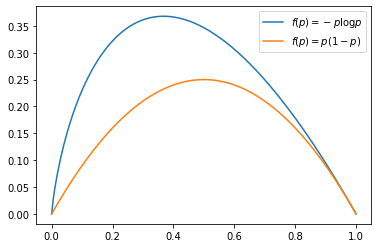

In [12]:
from matplotlib import pyplot as plt
import numpy as np
p = np.linspace(0, 1, 200)
h = -p * np.log(p + 1e-16) # + 1e-16 to prevent NaN
g = p * (1 - p)
plt.plot(p, h)
plt.plot(p, g)
plt.legend(['$f(p)=-p\log p$', '$f(p)=p(1-p)$'])
plt.show()

In [21]:
import numpy as np
class CART():
    def __init__(self) -> None:
        class node():
            def __init__(self, X = None, y = None, parent = None) -> None:
                self.feature, self.split, self.is_continuous = None, None, True
                self.X, self.y, self.num = X, y, 0 # a list to record data in this branch
                self.left, self.right, self.parent = None, None, parent
            
            def fit(self, is_continuous, max_depth = 10, min_samples_split = 1):
                """Train a CART by DFS."""
                X, y = np.array(self.X), np.array(self.y)
                if y.size > min_samples_split and y.min() != y.max() and max_depth > 0:
                    best_feature, best_split, best_gini, best_continuous = 0, 0, 2, True
                    for i, continuous in zip(range(X.shape[1]), is_continuous): # for each feature
                        if continuous: # continuous variable
                            sorts = np.argsort(X[:,i])
                            # compute gini coefficient at different partitions with vectorized operation
                            class_counts = np.array([np.cumsum(y[sorts] == c) for c in np.unique(y)])
                            class_counts, total = class_counts[:, :-1], class_counts[:,-1:]
                            class_counts_right = total - class_counts
                            gini = np.arange(1, y.size) * (1. - ((class_counts / class_counts.sum(axis = 0))**2).sum(axis = 0))
                            gini += np.arange(y.size-1, 0, -1) * (1. - ((class_counts_right / class_counts_right.sum(axis = 0))**2).sum(axis = 0))
                            gini_index = np.argmin(gini)
                            gini = gini[gini_index] / y.size
                            if gini < best_gini:
                                best_feature, best_split, best_gini, best_continuous = i, X[sorts[gini_index], i], gini, True
                                # print(f'Feature {i} Split {best_split}\tGini = {str(round(gini, 4))}')
                        else: # discrete variable
                            candidates = np.unique(X[:,i])
                            for cand in candidates:
                                data_true = np.extract(X[:,i] == cand, y)
                                counts_true = np.unique(data_true, return_counts = True)[1]
                                data_false = np.extract(X[:,i] != cand, y)
                                counts_false  = np.unique(data_false, return_counts = True)[1]

                                gini = data_true.size * (1. - ((counts_true / data_true.size)**2).sum())
                                gini += data_false.size * (1. - ((counts_false / data_false.size)**2).sum())
                                gini /= y.size
                                if gini < best_gini:
                                    best_feature, best_split, best_gini, best_continuous = i, cand, gini, False
                                    # print(f'Feature {i} Split {cand}\tGini = {str(round(gini, 4))}\tSize = {data_true.size} / {data_false.size} Split = {counts_true} {counts_false}')

                    # pushdown and perform DFS
                    if best_continuous:
                        data_true = (X[:,best_feature] <= best_split)
                        data_false = (X[:,best_feature] > best_split)
                    else:
                        data_true = (X[:,best_feature] == best_split)
                        data_false = (X[:,best_feature] != best_split)

                    y_true = np.extract(data_true, y)
                    y_false = np.extract(data_false, y)
                    if y_true.size == 0 or y_false.size == 0: # no improvement
                        return self._register_leaf()
                    
                    self.left = node(X = np.extract(np.tile(data_true.reshape((-1, 1)), (1, X.shape[1])), X).reshape((-1, X.shape[1])),
                                        y = y_true, parent = self)
                    self.right = node(X = np.extract(np.tile(data_false.reshape((-1, 1)), (1, X.shape[1])), X).reshape((-1, X.shape[1])),
                                        y = y_false, parent = self)

                    self.X, self.y, X, y = None, None, None, None # release memory
                    self.feature, self.split, self.is_continuous = best_feature, best_split, best_continuous
                    self.left.fit(is_continuous, max_depth = max_depth - 1, min_samples_split = min_samples_split)
                    self.right.fit(is_continuous, max_depth = max_depth - 1, min_samples_split = min_samples_split)
                else: # leaf node
                    self._register_leaf()

            def _register_leaf(self):
                self.X = None
                if (self.y is not None) and (not isinstance(self.y, int)) and len(self.y):
                    candidates, counts = np.unique(self.y, return_counts = True)
                    # self.y = candidates[np.argmax(counts)] # mode
                    self.y, self.num = dict(zip(candidates, counts / self.y.size)), self.y.size
                else: self.y, self.num = 0, 0
            
            def __str__(self, tab = 4, labels = None) -> str:
                if self.y is not None: 
                    # return f'Samples = {self.y}'
                    return 'Samples = [%d]{'%(self.num) + ', '.join('%d: %.2f%%'%(k, v * 100) for k, v in self.y.items()) + '}'
                s = ''
                for branch, sgn in zip((self.left, self.right), ('<=', '>') if self.is_continuous else ('==', '!=')):
                    if branch is not None:
                        feature_name = f'- {self.feature}' if labels is None else labels[self.feature]
                        s += f'\nFeature {feature_name} {sgn} {self.split} ?'
                        s += '\n' + ' '*tab + ('\n' + ' '*tab).join(line for line in branch.__str__(tab = tab, labels = labels).split('\n'))
                return s.lstrip('\n')
            
            def __call__(self, X, indices, class_number) -> str:
                """
                Predict by DFS. We should additionally provide the original indices of data for restoring orders.
                Return the probability of each class.
                """
                if self.y is not None:
                    prob = np.array([self.y.get(c) if self.y.get(c) is not None else 0 for c in range(class_number)])
                    return np.tile(prob.reshape((1, -1)), (len(indices), 1)), indices
                if self.is_continuous:
                    data_true = (X[:, self.feature] <= self.split)
                    data_false = (X[:, self.feature] > self.split)
                else:
                    data_true = (X[:, self.feature] == self.split)
                    data_false = (X[:, self.feature] != self.split)
                indices_true = np.extract(data_true, indices)
                indices_false = np.extract(data_false, indices)
                y_left = self.left(np.extract(np.tile(data_true.reshape((-1, 1)), (1, X.shape[1])), X)\
                                                        .reshape((-1, X.shape[1])), indices_true, class_number)
                y_right = self.right(np.extract(np.tile(data_false.reshape((-1, 1)), (1, X.shape[1])), X)\
                                                        .reshape((-1, X.shape[1])), indices_false, class_number)
                return tuple(np.concatenate((info_left, info_right)) for info_left, info_right in zip(y_left, y_right))
                

        self.root = node()
    
    def fit(self, X, y, is_continuous = None, **kwargs):
        """
        is_continuous: list of bool to specify whether each feature is continuous. Leave it None for auto inference.
        """
        self.root.X = X
        self.root.y = y
        self.is_continuous = is_continuous if is_continuous is not None\
                 else [np.unique(X[:,i]).size > 5 for i in range(X.shape[1])]
        # print('Continuous Features =', self.is_continuous)
        self.class_number = y.max() + 1
        self.root.fit(self.is_continuous, **kwargs)

    def __str__(self, tab = 4, labels = None) -> str:
        return self.root.__str__(tab = tab, labels = labels)
    
    def __call__(self, X, return_prob = False):
        prob, indices = self.root(X, np.arange(X.shape[0]), class_number = self.class_number)
        prob = prob[np.argsort(indices)]
        if not return_prob:
            prob = np.argmax(prob, axis = 1)
        return prob

In [22]:
import numpy as np
tree = CART()
data = np.array([[0,0,0,0,0],[0,0,0,1,0],[0,1,0,1,1],[0,1,1,0,1],[0,0,0,0,0],[1,0,0,0,0],[1,0,0,1,0],[1,1,1,1,1],[1,0,1,2,1],[1,0,1,2,1],[2,0,1,2,1],[2,0,1,1,1],[2,1,0,1,1],[2,1,0,2,1],[2,0,0,0,0]])
X, y = data[:,:-1], data[:,-1]
tree.fit(X, y, min_samples_split = 1, max_depth = 100)
print(tree)
print('\nTraining Acc = %.2f%%'%(100 * (tree(X, return_prob = False) == y).mean()))  # training acc must be 100%

Feature - 2 == 0 ?
    Feature - 1 == 0 ?
        Samples = [6]{0: 100.00%}
    Feature - 1 != 0 ?
        Samples = [3]{1: 100.00%}
Feature - 2 != 0 ?
    Samples = [6]{1: 100.00%}

Training Acc = 100.00%
